In [2]:
# Code to get central vs sidelobe flux for different 'phase differences'
# Import our packages
import dLuxToliman as dlT
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax.numpy as np

In [3]:
# Gonna do just airy disk toliman
wf_npixels = 2048 # highest resolution without crashing
diameter = 0.125
period = diameter/64
difference = np.pi

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)

layers = [
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayer
    )
]

In [4]:
psf_npixels = 4
pixel_scale = 1 
oversample = 8 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
wavelengths = np.array([585e-9])

flux = 1
source = dl.PointSource(wavelengths, np.zeros(2), flux)

# sidelobe layer for bottom left corner
sidelobeShiftLayer = dlT.SidelobeShiftLayer(wf_npixels, diameter, period, wavelengths[0], pixel_scale, oversample)

sidelobeLayers = [
    (
        'sidelobeShift',
        sidelobeShiftLayer
    ),
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayer
    )
]

opticsLobe = dl.AngularOpticalSystem(wf_npixels,diameter,sidelobeLayers,psf_npixels,pixel_scale,oversample)

In [5]:
psf = optics.model(source)
psfLobe = opticsLobe.model(source)

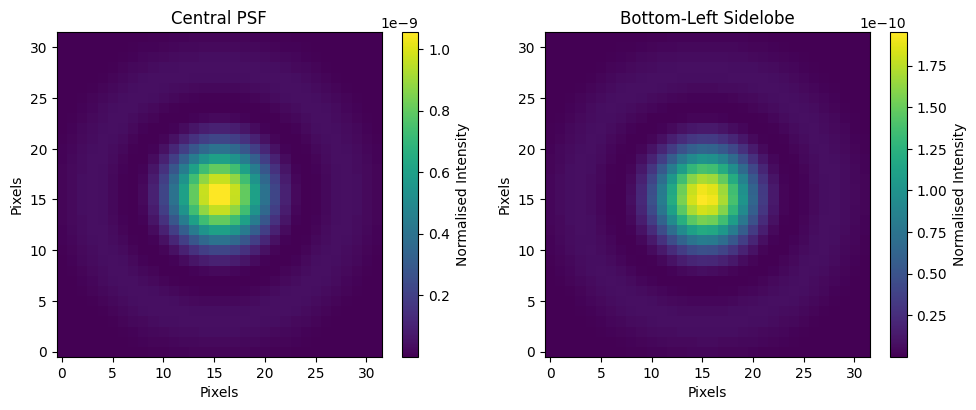

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(psf,origin='lower')
plt.title('Central PSF')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(label='Normalised Intensity')

plt.subplot(1,2,2)
plt.imshow(psfLobe,origin='lower')
plt.title('Bottom-Left Sidelobe')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(label='Normalised Intensity')

plt.tight_layout()
plt.show()

In [20]:
# Cool. Let's let it run for 10 values between 0.1pi and 1 pi
# Gonna do just airy disk toliman
wf_npixels = 1024 # lower res 
diameter = 0.125
period = diameter/32 # longer period

psf_npixels = 8
pixel_scale = 1 
oversample = 8 # high level oversample

wavelengths = np.array([0.5*585e-9])
flux = 1000000
source = dl.PointSource(wavelengths, np.zeros(2), flux)

differences = np.pi * np.arange(0, 2.6, 0.1)
centre_fluxes = np.zeros_like(differences)
sidelobe_fluxes = np.zeros_like(differences)

In [21]:
for idx, difference in enumerate(differences):
    apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
    gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)

    layers = [
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayer
        )
    ]

    optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
    # sidelobe layer for bottom left corner
    sidelobeShiftLayer = dlT.SidelobeShiftLayer(wf_npixels, diameter, period, wavelengths[0], pixel_scale, oversample)

    sidelobeLayers = [
        (
            'sidelobeShift',
            sidelobeShiftLayer
        ),
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayer
        )
    ]

    opticsLobe = dl.AngularOpticalSystem(wf_npixels,diameter,sidelobeLayers,psf_npixels,pixel_scale,oversample)

    psf = optics.model(source)
    psfLobe = opticsLobe.model(source)

    # saving the fluxes
    centre_fluxes = centre_fluxes.at[idx].set(np.sum(psf))
    
    sidelobe_fluxes = sidelobe_fluxes.at[idx].set(np.sum(psfLobe))

    print(centre_fluxes[idx], sidelobe_fluxes[idx])

0.6504361 0.00010668913
0.64643496 0.0011269541
0.63456154 0.0040876335
0.61519516 0.008826158
0.58895165 0.015082794
0.5566509 0.02251617
0.5192816 0.03072343
0.47795597 0.039264
0.4338607 0.047685258
0.388206 0.055548236
0.34217715 0.062452305
0.29688585 0.06805682
0.2533306 0.07209882
0.2123633 0.07440525
0.17466575 0.07489962
0.14073445 0.0736027
0.11087779 0.07062708
0.08522072 0.0661666
0.06371963 0.060481317
0.04618364 0.053878978
0.032301947 0.04669479
0.021674508 0.039270163
0.013844291 0.031932846
0.008328677 0.024978494
0.004648881 0.018655756
0.002355178 0.013155377


In [24]:
from scipy.optimize import curve_fit

x = differences/np.pi
y = sidelobe_fluxes/centre_fluxes

y2 = sidelobe_fluxes

def poly(x, K, a, b, c, d):
    return b * x**2 + c * x**3 + d * x**4

params, _ = curve_fit(poly, x, y)
params2, _ = curve_fit(poly, x, y2)

K, a, b, c, d = params
K2, a2, b2, c2, d2 = params2

x_fit = np.linspace(0, 2.5, 50)
y_fit = poly(x_fit, K, a, b, c, d)
y2_fit = poly(x_fit, K2, a2, b2, c2 ,d2)

/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_33868/1903851471.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(poly, x, y)
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_33868/1903851471.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  params2, _ = curve_fit(poly, x, y2)


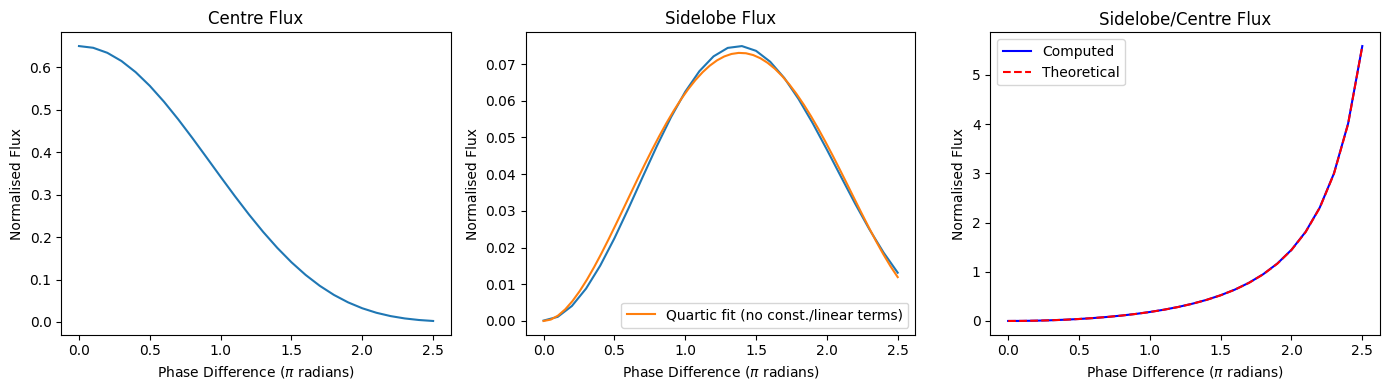

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi,centre_fluxes)

plt.subplot(1,3,2)
plt.title('Sidelobe Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi,sidelobe_fluxes)
plt.plot(x_fit, y2_fit,label='Quartic fit (no const./linear terms)')
plt.legend()

plt.subplot(1,3,3)
plt.title('Sidelobe/Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi,sidelobe_fluxes/centre_fluxes,label='Computed',color='blue')
#plt.plot(x_fit, y_fit,label='Quartic fit (no const./linear terms)',linestyle=':')

# from week 11 new stuff
from scipy.special import jv
plt.plot(differences/np.pi, jv(1, differences/4)**2/jv(0, differences/4)**2,label='Theoretical',linestyle='--',color='red')
# holy FVCK!! the analyitc solution works SO FVCKING WELL I AM A GENIUS.

plt.legend()

plt.tight_layout()
plt.show()

In [3]:
# Curious... a quick ask of chatgpt tells me that the ratios of the fluxes will be related by
# Ratios of different order bessel functions
# But the expression given by chatgpt was just entirely wrong
# Hmm... Jacobi-Anger expansion may prove helpful
# Will need to take a fourier transform.. luckily it linear
# Probably most straightforward way is to do 1D case of phase grating on plane wave
# Fraunhofer regime.
# Should be 'easy' to go from there to 2D case.
# The result is likely already known... somewhere. I'll figure it out for myself though.
# Everything here is yet more stuff to add to the thesis. 
# I could cover > half just talking how dLux and fourier optics works.. 
# And the theory behind simulation of sidelobes
# As well as the stuff that was supposed to go in a paper.

from scipy.special import jv


In [1]:
print(differences)

NameError: name 'differences' is not defined

In [10]:
print(jv(1, differences))
print(jv(0, differences))

[ 0.          0.1551497   0.29890907  0.42081693  0.5121907   0.5668241
  0.5814728   0.5560889   0.49378446  0.40052986  0.2846153   0.15592292
  0.0250763  -0.09745987 -0.20225078 -0.2816579  -0.33043587 -0.34611186
 -0.32911718 -0.28266385 -0.21238248]
[ 1.          0.97547776  0.90371263  0.7899622   0.64251184  0.4720012
  0.29056412  0.11085446 -0.0549604  -0.19615032 -0.3042422  -0.3736387
 -0.40198648 -0.3902685  -0.3426153  -0.26585725 -0.16886163 -0.06171486
  0.04517589  0.14198206  0.22027695]


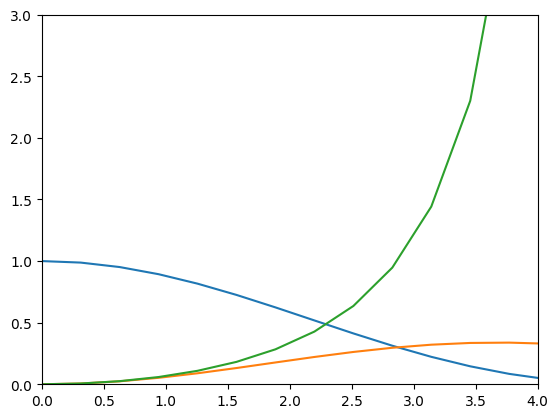

In [20]:
plt.plot(differences, np.abs(jv(0, differences/2))**2)
plt.plot(differences, np.abs(jv(1, differences/2))**2)
plt.plot(differences, (jv(1, differences/2)/jv(0,differences/2))**2)
plt.xlim(0,4)
plt.ylim(0,3)
plt.show()